## MNIST Digits Classification - Binary Case

In this exercise, you will implement a binary classification of MNIST digits. You will restrict the classification problem to two digits selected from the MNIST dataset.

You will conduct the follwing steps:
1. Prepare the data: 
    * Load the MNIST dataset
    * Select the digits
    * Split the dataset into train and test (we keep it simpler at the moment and ignore the validation set)
    * Standardize the data


2. Implement the training algorithm consisting of
    * sigmoid model function and predict function
    * cost function
    * parameter update rules 
    * optimize loop


3. Train the model for specific settings and get a feeling for how the training evolves
    * learning rate
    * number of epochs
    * CE / MSE loss
    * differently, randomly initialized weights
    
Some of the functions are already implemented. You just need to use these functions - but we highly recommend to inspect them and try to understand each and every line of the code. - In case you have suggestions for improvements we are very happy to receive your feedback.

Other functions need to be implemented by you. Carefully read the markdown sections and also the doc-strings and run the test cells often given in the cell right after. 

The following notation is used: <br>
<code>m</code>: Number of samples <br>
<code>n</code>: Number of features

### 1. Data Preparation

Some preparatory steps to be applied before training:
* Loading the data
* Some plots
* Filtering the dataset for two digits
* Splitting the dataset into train and test
* Normalizing the data

#### Data Folder

The data can be loaded by using suitable functionality in sklearn which will use a dedicated folder on your local disk for caching. Specify the folder to be used with a variable of your choice. 

In [1]:
### START YOUR CODE ###

# adjust:
path_data = './data/'

### END YOUR CODE ###

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

#### Plotting Utility

In [3]:
def plot_img(img, label, shape):
    """
    Plot the x array by reshaping it into a square array of given shape
    and print the label.
    
    Parameters:
    img -- array with the intensities to be plotted of shape (shape[0]*shape[1])
    label -- label 
    shape -- 2d tuple with the dimensions of the image to be plotted.
    """
    plt.imshow(np.reshape(img, shape), cmap=plt.cm.gray)
    plt.title("Label %i"%label)

def plot_digits(x,y,selection,shape,selected_digits, cols=5):
    """
    Plots the digits in a mosaic with up to 8 columns

    Arguments:
    x -- array of images of size (n,m)
    y -- array of labels of size (1,m)
    selection -- list of selection of samples to be plotted
    shape -- shape of the images (a 2d tuple)
    selected_digits -- tuple with the two selected digits (the first associated with label 1, the second with label 0)
    """
    if len(selection)==0:
        print("No images in the selection!")
        return
    cols = min(cols, len(selection))
    rows = int(len(selection)/cols)+1
    plt.figure(figsize=(20,4*rows))
    digit1 = selected_digits[0]
    digit2 = selected_digits[1]    
    for index, (image, label) in enumerate(zip(x.T[selection,:], y.T[selection,:])):
        digit = digit1 if label==1 else digit2
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, shape), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (selection[index],digit), fontsize = 12)
    plt.tight_layout()

#### Load Data 

Follow the instructions in the doc string of the <span style="color:blue">load_mnist</span>-method defined below so that you can load the "MNIST original" dataset.

Load the data MNIST dataset and plot the 17th image by using the <span style="color:blue">plot_image</span>-method defined above.

In [4]:
from sklearn.datasets import fetch_openml

def load_mnist(datadir):
    """
    Loads the mnist dataset, prints the shape of the dataset and 
    returns the array with the images, the array with associated labels 
    and the shape of the images. Possibly, the data needs to be fetched 
    manually beforehand and put into the folder DATA_HOME/mldata 
    (see https://stackoverflow.com/questions/53096977/mnist-data-download-from-sklearn-datasets-gives-timeout-error)
    
    Returns:
    x -- array with images of shape (784,m) where m is the number of images
    y -- array with associated labels with shape (m,) where m is the number of images
    shape -- (28,28)
    """
    mnist = fetch_openml('mnist_784', data_home=datadir)
    x, y = mnist['data'].T, np.array(mnist['target'], dtype='int').T
    m = x.shape[1]
    y = y.reshape(1,m)
    print("Loaded MNIST original:")
    print("Image Data Shape" , x.shape)
    print("Label Data Shape", y.shape)
    return x,y,(28,28)

In [5]:
x, y, shape = load_mnist(path_data)

Loaded MNIST original:
Image Data Shape (784, 70000)
Label Data Shape (1, 70000)


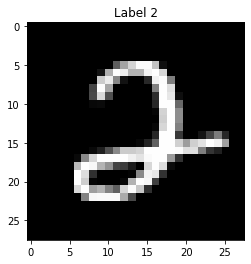

In [6]:
### START YOUR CODE ###
plot_img(x[:, 16], label=y[:, 16], shape=shape)
### END YOUR CODE ###

#### Filter the data for two selected digits and split it into train/test

Load the MNIST dataset (by using <span style="color:blue">load_mnist</span> from above), filter it to only use the digits '1' and '7' (by using the method <span style="color:blue">filter_digits</span> and split up the result further into a training and a test set (by using the <span style="color:blue">prepare_train_test</span>). Use a 80-20 split of the data into train and test.

Furthermore, bring the input data (x) into the shape (n,m) where n is the number of input features and m the number of samples.  
As a result, you can run the test which should not produce any exception.

In [7]:
def filter_digits(x, y, selected_digits):
    """
    Filter the dataset for given two digits (label values between 0 and 9).
    The samples with the first digit will be associated with the label 1, the second with 0.  
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (1,m) where m is the number of samples
    digits -- tuple with two values
    
    Returns:
    x1 -- filtered list of images of shape (n,m1)
    y1 -- filtered list of labels of shape (1,m1)
    """
    # select two given digits - will the train a model that learns to differentiate between the two
    
    digit1, digit2 = selected_digits
    
    idx_digit1 = (y[0, :] == digit1)
    idx_digit2 = (y[0, :] == digit2)
    
    idx_combined = (idx_digit1 | idx_digit2)
    
    x1 = x[:, idx_combined]
    y1 = y[:, idx_combined]
    
    idx_digit1 = (y1[0, :] == digit1)
    idx_digit2 = (y1[0, :] == digit2)
    
    y1[:, idx_digit1] = 1
    y1[:, idx_digit2] = 0
    

    print("Selecting {} images with digit {} and {} images with digit {}".format(
        np.sum(idx_digit1),digit1,np.sum(idx_digit2),digit2))
    return x1,y1

In [8]:
from sklearn.model_selection import train_test_split

def prepare_train_test(x, y, test_size=0.20):
    """
    Split the dataset consisting of an array of images (shape (m,n)) and an array of labels (shape (n,))
    into train and test set.
    
    Parameters:
    x -- Array of images of shape (n,m) where m is the number of samples
    y -- Array of labels of shape (m,) where m is the number of samples
    test_size -- fraction of samples to reserve as test sample
    
    Returns:
    x_train -- list of images of shape (n,m1) used for training
    y_train -- list of labels of shape (1,m1) used for training
    x_test -- list of images of shape (n,m2) used for testing
    y_test -- list of labels of shape (1,m2) used for testing
    """
    # split 
    # We use the functionality of sklearn which assumes that the samples are enumerated with the first index 
    x_train, x_test, y_train, y_test = train_test_split(x.T, y.T, test_size=0.20, random_state=1)

    # reshape - transpose back the output obtained from the train_test_split-function
    x_train = x_train.T
    x_test = x_test.T
    m_train = x_train.shape[1]
    m_test = x_test.shape[1]
    y_train=y_train.reshape(1,m_train)
    y_test=y_test.reshape(1,m_test)

    print("Shape training set: ", x_train.shape, y_train.shape)
    print("Shape test set:     ", x_test.shape, y_test.shape)
    
    return x_train, x_test, y_train, y_test

In [9]:
### START YOUR CODE ###
# call the arrays x_train1, y_train, x_test1, y_test
x1, y1 = filter_digits(x, y, selected_digits=(1,7))
x_train1, x_test1, y_train, y_test = prepare_train_test(x1, y1, test_size=0.2)
### END YOUR CODE ###

Selecting 7877 images with digit 1 and 7293 images with digit 7
Shape training set:  (784, 12136) (1, 12136)
Shape test set:      (784, 3034) (1, 3034)


In [10]:
## TEST ##
np.testing.assert_array_equal(x_train1.shape, (784, 12136))
np.testing.assert_array_equal(y_train.shape, (1, 12136))
np.testing.assert_array_equal(x_test1.shape, (784, 3034))
np.testing.assert_array_equal(y_test.shape, (1, 3034))

#### Data Normalisation

Normalize the data - by using z-normalization computed over all pixels. 
Test that the result is expected.

In [11]:
def normalize(x_train,x_test):
    """
    Normalizes the pixels values of the images - mean and stdev are computed from the training set.
    
    Parameters:
    x_train -- Array of training samples of shape (n,m1) where n,m1 are the number of features and samples, respectively.  
    x_test -- Array of test samples of shape (n,m2) where n,m2 are the number of features and samples, respectively. 
    
    Returns:
    The arrays with the normalized train and test samples.  
    """
    ### START YOUR CODE ###
    mean = np.mean(x_train)
    std = np.std(x_train)
    
    mu = x_train.mean()
    sigma = x_train.std()
    
    x_train = (x_train - mu) / sigma
    x_test = (x_test - mu) / sigma 
    
    ### END YOUR CODE ###
    return x_train, x_test

In [12]:
## TEST ##
xunittest_train = np.array([0,3,2,5,10,9]).reshape(1,6).astype(np.float64)
xunittest_test = np.array([11,20,1,-1]).reshape(1,4).astype(np.float64)
x1,x2 = normalize(xunittest_train, xunittest_test)
np.testing.assert_array_almost_equal(x1,np.array([-1.33342142, -0.50578054, -0.78166083,  0.04598005,  1.42538152,  1.14950122]).reshape(1,6),decimal=8)
np.testing.assert_array_almost_equal(x2,np.array([1.70126181,  4.18418446, -1.05754113, -1.60930171]).reshape(1,4),decimal=8)

In [13]:
x_train,x_test = normalize(x_train1,x_test1)

### 2. Implementation

#### Perceptron-Model

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z
    Arguments:
    z -- A scalar or numpy array of any size.
    Return:
    s -- sigmoid(z)
    """
    ### START YOUR CODE ###
    return 1 / (1 + np.exp(-z))
    ### END YOUR CODE ###

In [15]:
# TEST
zunittest = np.array([1,-2,2,0]).reshape(1,4)
yunittest = sigmoid(zunittest)
ytrue = np.array([0.73105858, 0.11920292, 0.88079708, 0.5]).reshape(1,4)
np.testing.assert_array_almost_equal(yunittest,ytrue,decimal=8)

In [16]:
def predict(w, b, X, round=False):
    '''
    Compute the prediction for each of the m samples by using the parameters (w, b).
    
    Arguments:
    w -- weights, a numpy array with shape (1, n)
    b -- bias, a scalar
    X -- data of size (n,m)
    round -- return the score (number in [0,1]) if False, or round to 0 or 1 if True.
    
    Returns:
    predictions -- a numpy array (vector) containing all predictions
    '''    
    ### START YOUR CODE ### 
    pred = sigmoid(w.dot(X) + b)
    if round: return np.round(pred)
    return pred
    ### END YOUR CODE ###

In [17]:
# TEST
X = np.array([1,-2,2,1]).reshape(4,1)
w = np.array([1,1,0.75,0]).reshape(1,4)
b = -0.25

yunittest = predict(w,b,X)
ytrue = np.array([sigmoid(0.25)]).reshape(1,1)
np.testing.assert_array_almost_equal(yunittest,ytrue,decimal=8)

yunittest = predict(w,b,X, round=True)
ytrue = np.array([1]).reshape(1,1)
np.testing.assert_array_almost_equal(yunittest,ytrue,decimal=8)

#### Cost Function

* Cross-Entropy Cost Function
* Mean Square Error Function

In [18]:
def cost_CE(ypred, y, eps=1.0e-12):
    """
    Computes the cross entropy cost function for given predicted values and labels.
    It clips (using numpy clip) predicted values to be in the interval [eps,1-eps] so that numerical 
    issues with the calculation of logarithm are avoided.
    
    Parameters:
    ypred -- Predicted values, a numpy array with shape (1,m).
    y -- Ground truth values (labels 0 or 1), a numpy array with shape (1,m)
    
    Returns:
    Cross Entropy Cost
    """
    # sanity checks:
    try:
        if ypred.shape != y.shape:
            raise AttributeError("The two input arguments ypred and y should be numpy arrays of the same shape.")
    except Exception:
        raise AttributeError("Wrong type of argument - ypred and y should be a numpy array")

    # clip predicted values and compute the cost
    
    ### START YOUR CODE ### 
    ypred = np.clip(ypred, eps, 1-eps)
    J = -(y*np.log(ypred)+(1-y)*np.log(1-ypred)).mean()
    ### END YOUR CODE ### 
    return J

In [19]:
# TEST
# CASE 1: Numeric value computed correctly
yhat = np.array([0.1,0.2,0.5,0.8,0.9,1.0]).reshape(1,6)
yunittest = np.array([0,1,1,0,1,1]).reshape(1,6)
J = cost_CE(yhat,yunittest)
Jtrue = -(np.log(0.2)+np.log(0.5)+np.log(0.9)+np.log(1.0)+np.log(0.9)+np.log(0.2))/6
np.testing.assert_array_almost_equal(J,Jtrue,decimal=8)

# CASE 2: Both arguments should be numpy arrays of the same shape
try:
    cost_CE(1,1)
except AttributeError:
    print("Exception ok")
    
# CASE 3: Both arguments should be numpy arrays of the same shape
try:
    cost_CE(yhat,1)
except AttributeError:
    print("Exception ok")

Exception ok
Exception ok


In [20]:
def cost_MSE(ypred, y):
    """
    Computes the mean square error cost function for given predicted values and labels.
    
    Parameters:
    ypred -- A scalar or numpy array with shape (1,m).
    y -- A scalar or numpy array with shape (1,m).
    
    Returns:
    MSE Cost
    """    
    # sanity checks:
    try:
        if ypred.shape != y.shape:
            raise AttributeError("The two input arguments ypred and y should be numpy arrays of the same shape.")
    except Exception:
        raise AttributeError("Wrong type of argument - ypred and y should be a numpy array")

    ### START YOUR CODE ### 
    J = 1/(2*y.shape[1]) * np.sum((ypred - y)**2)
    ### END YOUR CODE ### 
    return J

In [21]:
# TEST
# CASE 1: Numeric value computed correctly
yhat = np.array([0.1,0.2,0.5,0.8,0.9,1.0]).reshape(1,6)
yunittest = np.array([0,1,1,0,1,1]).reshape(1,6)
J = cost_MSE(yhat,yunittest)
Jtrue = (0.01+0.64+0.25+0.64+0.01)/12
np.testing.assert_almost_equal(J,Jtrue,decimal=8)

# CASE 2: Both arguments should be numpy arrays of the same shape
try:
    cost_MSE(1,1)
except AttributeError:
    print("Exception ok")
    
# CASE 3: Both arguments should be numpy arrays of the same shape
try:
    cost_MSE(yhat,1)
except AttributeError:
    print("Exception ok")

Exception ok
Exception ok


#### Update Rules for the Parameters

Different update rules associated with the different cost functions.

In [22]:
def step_CE(X, Y, Ypred):
    """
    Computes the update of the weights and bias from the gradient of the cross entropy cost. 
    
    Arguments:
    X -- data of size (n, m)
    Y -- label vector (1, m)
    Ypred -- predicted scores (1, m)

    Returns: 
    Dictionary with the gradient w.r.t. weights ('dw') and w.r.t. bias ('db')
    """

    ### START YOUR CODE ### 
    d = Y - Ypred
    dw = -(d * X).mean(axis=1).reshape(1, -1)
    db = -(d).mean().reshape(1, -1)
    ### END YOUR CODE ### 
    
    return {"dw": dw, "db": db}

In [23]:
# TEST
xunittest = np.array([[1,2,3],[4,5,6]]).reshape(2,3)
yunittest = np.array([1,0,1]).reshape(1,3)
ypred = np.array([0.8,0.3,0.9]).reshape(1,3)

res = step_CE(xunittest,yunittest,ypred)
dwtrue = np.array([0.033333333,0.033333333]).reshape(1,2)
np.testing.assert_almost_equal(res["dw"],dwtrue,decimal=8)

In [24]:
def step_MSE(X, Y, Ypred):
    """
    Computes the update of the weights and bias from the gradient of the mean square error cost. 

    Arguments:
    X -- data of size (n, m)
    Y -- label vector (1, m)
    Ypred -- predicted scores (1, m)

    Returns:
    Dictionary with the gradient w.r.t. weights ('dw') and w.r.t. bias ('db')
    """
    
    ### START YOUR CODE ### 
    d = Ypred*(1-Ypred)*(Ypred-Y)
    dw = (d * X).mean(axis=1).reshape(1, -1)
    db = (d).mean().reshape(1, -1)
    ### END YOUR CODE ### 
        
    return {"dw": dw, "db": db}

In [25]:
# TEST
xunittest = np.array([[1,2,3],[4,5,6]]).reshape(2,3)
yunittest = np.array([1,0,1]).reshape(1,3)
ypred = np.array([0.8,0.3,0.9]).reshape(1,3)

res = step_MSE(xunittest,yunittest,ypred)
dwtrue = np.array([0.02233333,0.04433333]).reshape(1,2)
np.testing.assert_almost_equal(res["dw"],dwtrue,decimal=8)

#### Error rate

In [26]:
def error_rate(Ypred, Y):
    """
    Computes the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    Ypred -- predicted scores with values in [0,1], array of shape (1,m)
    Y -- ground truth labels with values in {0,1}, array of shape (1,m)

    Returns:
    error_rate 
    """
    ### START YOUR CODE ### 
    return ((Ypred > 0.5) != Y).sum()/Y.reshape(-1).shape[0]
    ### END YOUR CODE ### 

In [27]:
# TEST
yunittest = np.array([1,0,1,1,0])
ypred = np.array([0.9,0.1,0.4,0.8,0.7])
np.testing.assert_almost_equal(error_rate(ypred, yunittest),0.4,decimal=8)

#### Initialize Parameters

First we provide a utility method to generate properly intialized parameters. You will learn later more details about it.

In [28]:
def initialize_params(n, random=False):
    """
    This function provides initialized parameters: a vector of shape (1,n) as weights and a scalar equal to zero as bias. 
    
    Argument:
    n -- size of the w vector we want (number of features)
    rand -- if set to True stand norma distributed values are set for the weights; otherwise zeros are used.
    
    Returns:
    w -- initialized vector of shape (1,n)
    b -- initialized scalar (corresponds to the bias)
    """
    if random:
        w = np.random.randn(*(1,n)) / np.sqrt(n)
    else:
        w = np.zeros((1,n))
    b = 0.0
    
    return w, b

In [29]:
# TEST
w0, b0 = initialize_params(100)
np.testing.assert_array_equal(w0.shape, (1,100))

w0, b0 = initialize_params(100, random=True)
np.testing.assert_array_equal(w0.shape, (1,100))
np.testing.assert_almost_equal(np.mean(w0),0.0,decimal=0.1)

#### Metrics Class

For not littering the optimization loop with code to keep track of the learning results over the epochs we defined a suitable metrics class that keeps all the data (cost function, classification error vs epochs). It also provides utility methods for updating, printing values or plotting the learning curves.

It is defined as python class the metrics object then needs to be instantiated from. It means that some small knowledge about object-oriented programming is needed here.   

In [30]:
class Metrics():
    """
    Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
    and for creating learning curves that are a useful tool for analyzing the quality of the learning.
    """
    
    def __init__(self, cost_function=cost_CE):
        """
        Constructor for a metrics object. 
        Initializes all the statistics to track in form of python lists.
        
        Parameters:
        cost_function -- a function object that allows to compute the cost.
        """
        self.epochs = []
        self.train_costs = []
        self.test_costs = []
        self.train_errors = []
        self.test_errors = []
        self.stepsize_w = []
        self.stepsize_b = []
        self.cost_function = cost_function
    
    def update(self, epoch, ypred_train, y_train, ypred_test, y_test, dw, db):
        """
        Allows to update the statistics to be tracked for a new epoch.
        The cost is computed by using the function object passed to the constructor.
        
        Parameters:
        epoch -- Epoch
        ypred_train -- predicted values on the training samples, a numpy array of shape (1,m1)
        y_train -- ground truth labels associated with the training samples, a numpy array of shape (1,m1)
        ypred_test -- predicted values on the test samples, a numpy array of shape (1,m2)
        y_test -- ground truth labels associated with the test samples, a numpy array of shape (1,m2)
        dw -- some lenght measure for the gradient w.r.t. the weights, a scalar
        db -- gradient w.r.t. the bias, a scalar
        """       
        Jtrain = self.cost_function(ypred_train, y_train)
        Jtest = self.cost_function(ypred_test, y_test)
        train_error = error_rate(ypred_train, y_train)
        test_error = error_rate(ypred_test, y_test)

        self.epochs.append(epoch)
        self.train_costs.append(Jtrain)
        self.test_costs.append(Jtest)
        self.train_errors.append(train_error)
        self.test_errors.append(test_error)
        self.stepsize_w.append(dw)
        self.stepsize_b.append(db)
        
    def print_latest_errors(self):
        print ("Train/test error after epoch %i: %f, %f (min: %f, %f)" %(self.epochs[-1], self.train_errors[-1], self.test_errors[-1], min(self.train_errors), min(self.test_errors)))
    
    def print_latest_costs(self):
        print ("Train/test cost after epoch %i: %f, %f" %(self.epochs[-1], self.train_costs[-1], self.test_costs[-1]))

    def plot_cost_curves(self, ymin=None, ymax=None, logy=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_costs, "b-", label="train")
            plt.semilogy(self.epochs, self.test_costs, "r-", label="test")
        else:
            plt.plot(self.epochs, self.train_costs, "b-", label="train")
            plt.plot(self.epochs, self.test_costs, "r-", label="test")            
            minvalue = 0.0
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(minvalue,np.min(self.train_costs)),max(minvalue,np.min(self.test_costs))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_costs),np.max(self.test_costs)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()        
    
    def plot_error_curves(self, ymin=None, ymax=None, logy=True, show=True):
        minvalue = 1e-5
        if logy:
            plt.semilogy(self.epochs, self.train_errors, "b-", label="train")
            plt.semilogy(self.epochs, self.test_errors, "r-", label="test")
        else:
            plt.plot(self.epochs, self.train_errors, "b-", label="train")
            plt.plot(self.epochs, self.test_errors, "r-", label="test")            
            minvalue = 0.0
        plt.ylabel('Errors')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(minvalue,np.min(self.train_errors)),max(minvalue,np.min(self.test_errors))) * 0.8
        if not ymax:
            ymax = max(np.max(self.train_errors),np.max(self.test_errors)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        if show:
            plt.show()     

    def plot_stepsize_curves(self, ymin=None, ymax=None):
        plt.semilogy(self.epochs, self.stepsize_w, label="dw")
        plt.semilogy(self.epochs, self.stepsize_b, label="db")
        plt.ylabel('Step Sizes (dw,db)')
        plt.xlabel('Epochs')
        xmax = self.epochs[-1]
        if not ymin:
            ymin = min(max(1e-5,np.min(self.stepsize_w)),max(1e-5,np.min(self.stepsize_b))) * 0.8
        if not ymax:
            ymax = max(np.max(self.stepsize_w),np.max(self.stepsize_b)) * 1.2
        plt.axis([0,xmax,ymin,ymax])
        plt.legend()
        plt.show()

In [31]:
help(Metrics)

Help on class Metrics in module __main__:

class Metrics(builtins.object)
 |  Metrics(cost_function=<function cost_CE at 0x7f93e17e2940>)
 |  
 |  Allows to collect statistics (such as classification error or cost) that are of interest over the course of training
 |  and for creating learning curves that are a useful tool for analyzing the quality of the learning.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cost_function=<function cost_CE at 0x7f93e17e2940>)
 |      Constructor for a metrics object. 
 |      Initializes all the statistics to track in form of python lists.
 |      
 |      Parameters:
 |      cost_function -- a function object that allows to compute the cost.
 |  
 |  plot_cost_curves(self, ymin=None, ymax=None, logy=True)
 |  
 |  plot_error_curves(self, ymin=None, ymax=None, logy=True, show=True)
 |  
 |  plot_stepsize_curves(self, ymin=None, ymax=None)
 |  
 |  print_latest_costs(self)
 |  
 |  print_latest_errors(self)
 |  
 |  update(self, epoch, ypred_t

#### Optimisation

In [32]:
def optimize(w, b, x_train, y_train, x_test, y_test, nepochs, alpha, cost_type="CE", debug = False):
    """
    This function optimizes w and b by running (batch) gradient descent.
    
    Arguments:
    w -- weights, a numpy array of size (1,n)
    b -- bias, a scalar
    x -- array of samples of shape (n,m)
    y -- ground truth labels vector (containing 0 or 1) of shape (1, m)
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    cost -- type of cost function to use for the opimisation (CE or MSE)
    debug -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    metrics -- Metrics object that contains metrics collected while training was in progress    
    """ 
    if "CE" == cost_type:
        cost_function = cost_CE
        step_function = step_CE
    else:
        cost_function = cost_MSE
        step_function = step_MSE
    
    metrics = Metrics(cost_function=cost_function)

    # compute and set the initial values for the metrics curves  
    ypred_train = predict(w,b,x_train)
    ypred_test = predict(w,b,x_test)    
    metrics.update(0, ypred_train, y_train, ypred_test, y_test, 0, 0)
    
    ### START YOUR CODE ###
    for i in range(nepochs):
        print(f"Epoch ({i+1}/{nepochs})", end="\r")
        res = step_function(x_train, y_train, ypred_train)

        w -= alpha * res["dw"]
        b -= alpha * res["db"]
    
        ypred_train = predict(w,b,x_train)
        ypred_test = predict(w,b,x_test)    
        metrics.update(i, ypred_train, y_train, ypred_test, y_test, np.linalg.norm(alpha * res["dw"]), alpha * res["db"])
        
        if (debug and i % 100 == 0 and i > 0):
            clear_output(wait=True)
            metrics.plot_cost_curves()
            metrics.plot_error_curves()
            metrics.plot_stepsize_curves()
        
    ### END YOUR CODE ### 
        
    # finally, we print the latest metrics values and return
    #metrics.print_latest_costs()
    metrics.print_latest_errors()

    return {"w": w, "b": b}, metrics

### 3. Run the Training for Specific Settings

#### A first run
Compose that all in a single "pipeline" starting with selecting the digits in the data preparation up to performing the training.

Make a first test run with 
* learning rate 0.2
* 500 epochs
* CE loss

The training should not take more than a couple of seconds.

In [33]:
# preparing data
selected_digits = (1,7)

### START YOUR CODE ###
x_filtered, y_filtered = filter_digits(x, y, selected_digits=selected_digits)
x_train, x_test, y_train, y_test = prepare_train_test(x_filtered, y_filtered, test_size=0.2)
### END YOUR CODE ###

Selecting 7877 images with digit 1 and 7293 images with digit 7
Shape training set:  (784, 12136) (1, 12136)
Shape test set:      (784, 3034) (1, 3034)


In [34]:
# run the training here

### START YOUR CODE ###
np.random.seed(1) # this makes the results reproduceable - change this if you want to see other initial weights

learning_rate = 0.2
nepochs = 500

w, b = initialize_params(n=x_train.shape[0], random="False")

model, metrics = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=500, alpha=0.2, cost_type="CE", debug=False)
### END YOUR CODE ###

<ipython-input-14-77d05490f2aa>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Train/test error after epoch 499: 0.002719, 0.003955 (min: 0.002390, 0.002966)


#### Plot Learning Curves

Cost <br>
Error Rate <br>
Learning Speed (Lenght of Parameter Change)<br>

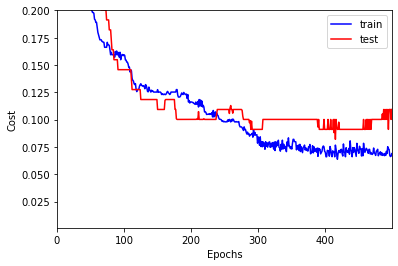

In [35]:
metrics.plot_cost_curves(ymin=0.001, ymax=0.2,logy=False)

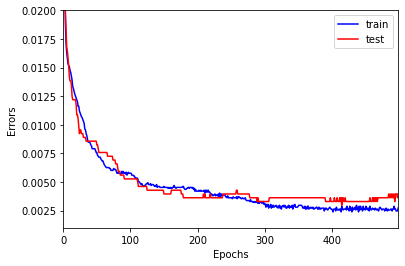

In [36]:
metrics.plot_error_curves(ymin=0.001, ymax=0.02,logy=False)

/opt/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


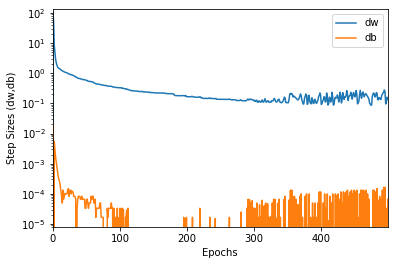

In [37]:
metrics.plot_stepsize_curves()

#### Plot misclassified digits 

Plot misclassified digits and judge (with your human eye) whether the given digits should have been correctly recognized by the model or whether the digit is written with a bad handwriting.

<ipython-input-14-77d05490f2aa>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


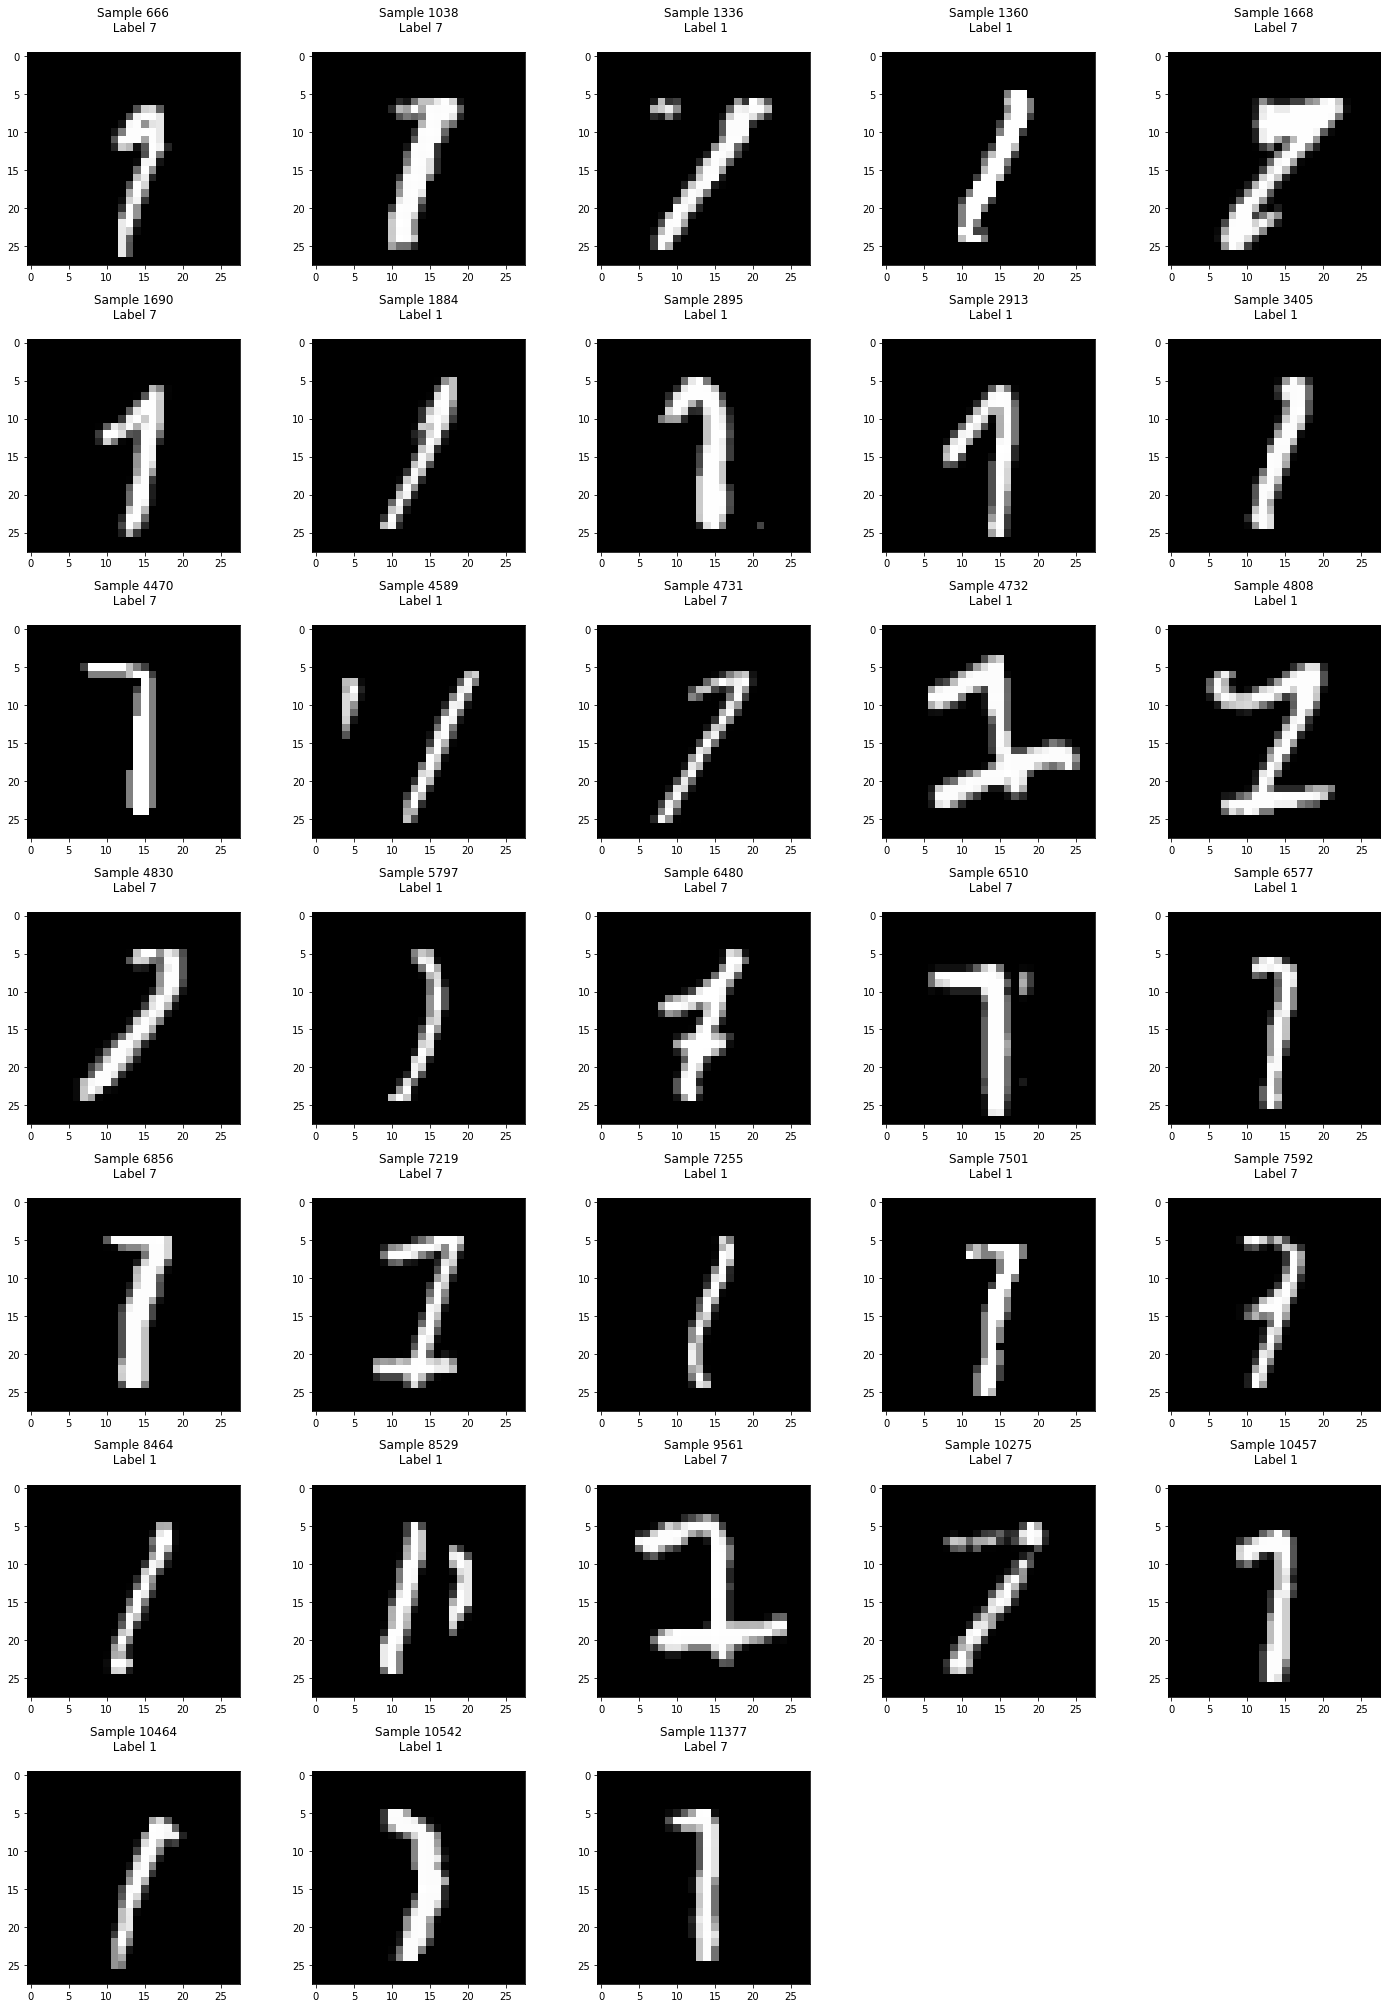

In [39]:
### START YOUR CODE ### 
ypred = predict(model["w"], model["b"], x_train) > 0.5

false_preds = (ypred != y_train)

false_preds.sum()

plot_digits(x_train,y_train,np.argwhere(false_preds > 0)[:, 1],shape,selected_digits, cols=5)
### END YOUR CODE ### 

From the images it is clear that the misclassified images are written in a very bad handwritting. Especially the in the case of the number 1 it is obvious that it should be written as a straight line without an additional line on the top. Most of the misclassified ones do have that additional line. 

#### Evaluate Dependency on Learning Rate and #Epochs 

Try different learning rates (e.g. 0.1, 0.2, 0.5, 1.0) and explore how many epochs you need to obtain stable results.
* Inspect the error rate curves to make sure that the rates reported in the table are stable. 
* Describe the characteristic behavior of the error rate curves for different learning rates. 
* Summarize the results in a small table with (learning rate, # epochs, training and test error rates.
* Estimate the error bar in the estimation of the test error rates when varying the iniitial weights.

| Epochs / Learning Rate        | 0.1             | 0.2             | 0.5             | 1.0             |
| ----------------------------- |:---------------:|:---------------:|:---------------:|:---------------:|
| 100                           | 0.56 / 0.63 % | 0.57 / 0.56 % | 0.60 / 0.69 % | 0.62 / 0.59 % |
| 500                           | 0.26 / 0.40 % | 0.26 / 0.43 % | 0.25 / 0.40 % | 0.26 / 0.40 % |
| 1000                          | 0.09 / 0.46 % | 0.22 / 0.46 % | 0.07 / 0.53 % | 0.12 / 0.53 % |

epochs: 100, learning rate: 0.1


<ipython-input-14-77d05490f2aa>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Train/test error after epoch 99: 0.005850, 0.004944 (min: 0.005768, 0.004944)

epochs: 500, learning rate: 0.1
Train/test error after epoch 499: 0.002390, 0.003296 (min: 0.002390, 0.002966)

epochs: 1000, learning rate: 0.1
Train/test error after epoch 999: 0.001730, 0.004614 (min: 0.000577, 0.002966)

epochs: 100, learning rate: 0.2
Train/test error after epoch 99: 0.005521, 0.006262 (min: 0.005521, 0.006262)

epochs: 500, learning rate: 0.2
Train/test error after epoch 499: 0.002472, 0.003626 (min: 0.002307, 0.003296)

epochs: 1000, learning rate: 0.2
Train/test error after epoch 999: 0.000082, 0.005274 (min: 0.000082, 0.003626)

epochs: 100, learning rate: 0.5
Train/test error after epoch 99: 0.005933, 0.005603 (min: 0.005850, 0.005603)

epochs: 500, learning rate: 0.5
Train/test error after epoch 499: 0.002802, 0.003626 (min: 0.002637, 0.003296)

epochs: 1000, learning rate: 0.5
Train/test error after epoch 999: 0.001483, 0.004614 (min: 0.000906, 0.003296)

epochs: 100, learning ra

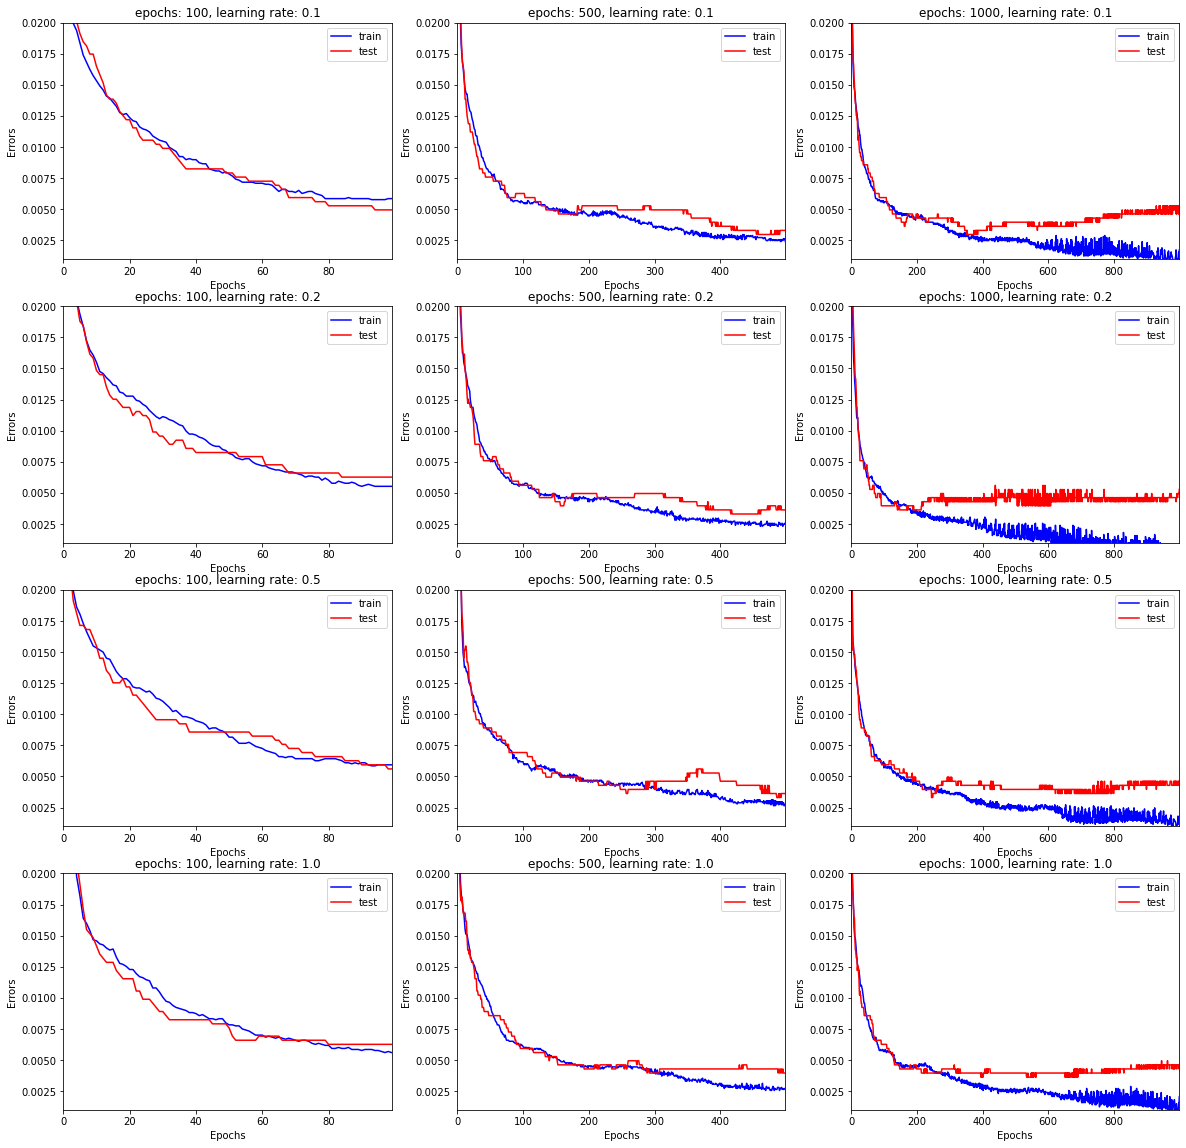

In [40]:
import itertools

learning_rates = [0.1, 0.2, 0.5, 1.0]
nepochs = [100, 500, 1000]

fig, axes = plt.subplots(4, 3, figsize=(20, 20)) 

i = 0
for lr, ep in itertools.product(learning_rates, nepochs):
    plt.sca(axes[int(i//3), int(i-int(i//3)*3)])
    i += 1
    
    print(f"epochs: {ep}, learning rate: {lr}")
    plt.gca().set_title(f"epochs: {ep}, learning rate: {lr}")
    w, b = initialize_params(n=x_train.shape[0], random="False")

    model, metrics = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=ep, alpha=lr, cost_type="CE", debug=False)
    metrics.plot_error_curves(ymin=0.001, ymax=0.02,logy=False, show=False)
    
    print("")

#### Evaluate Dependency on Cost Function

Compare the train and test error curves for the learning rate 0.2 when using cross-entropy loss with when using the mean square error loss.

<ipython-input-14-77d05490f2aa>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Train/test error after epoch 499: 0.002390, 0.003955 (min: 0.002225, 0.003296)


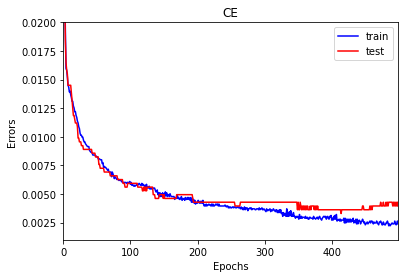

Train/test error after epoch 499: 0.009476, 0.009558 (min: 0.009476, 0.009558)


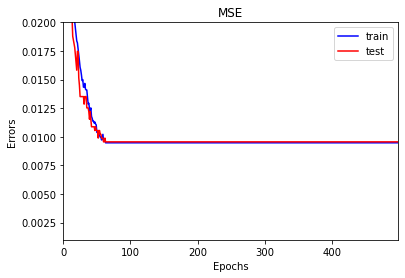

In [41]:
learning_rate = 0.2
nepochs = 500

w, b = initialize_params(n=x_train.shape[0], random="False")
model, metrics = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=500, alpha=0.2, cost_type="CE", debug=False)
plt.title("CE")
metrics.plot_error_curves(ymin=0.001, ymax=0.02,logy=False)


w, b = initialize_params(n=x_train.shape[0], random="False")
model, metrics = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=500, alpha=0.2, cost_type="MSE", debug=False)
plt.title("MSE")
metrics.plot_error_curves(ymin=0.001, ymax=0.02,logy=False)

#### (Optional) Determine the error rates for different digit pairs

For which digit pairs do you obtain good classification results (measured with the test error rates) - for which not so good?

Selecting 6903 images with digit 0 and 7877 images with digit 1
Shape training set:  (784, 11824) (1, 11824)
Shape test set:      (784, 2956) (1, 2956)


<ipython-input-14-77d05490f2aa>:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Train/test error after epoch 499: 0.001099, 0.000677 (min: 0.001099, 0.000677)
Selecting 6903 images with digit 0 and 6990 images with digit 2
Shape training set:  (784, 11114) (1, 11114)
Shape test set:      (784, 2779) (1, 2779)
Train/test error after epoch 499: 0.004679, 0.009356 (min: 0.004679, 0.007557)
Selecting 6903 images with digit 0 and 7141 images with digit 3
Shape training set:  (784, 11235) (1, 11235)
Shape test set:      (784, 2809) (1, 2809)
Train/test error after epoch 499: 0.003293, 0.008188 (min: 0.002581, 0.006764)
Selecting 6903 images with digit 0 and 6824 images with digit 4
Shape training set:  (784, 10981) (1, 10981)
Shape test set:      (784, 2746) (1, 2746)
Train/test error after epoch 499: 0.002368, 0.006555 (min: 0.002003, 0.005098)
Selecting 6903 images with digit 0 and 6313 images with digit 5
Shape training set:  (784, 10572) (1, 10572)
Shape test set:      (784, 2644) (1, 2644)
Train/test error after epoch 499: 0.010499, 0.016263 (min: 0.009554, 0.01399

Train/test error after epoch 499: 0.004318, 0.008082 (min: 0.003675, 0.007348)
Selecting 6313 images with digit 5 and 6825 images with digit 8
Shape training set:  (784, 10510) (1, 10510)
Shape test set:      (784, 2628) (1, 2628)
Train/test error after epoch 499: 0.041294, 0.049848 (min: 0.040057, 0.047184)
Selecting 6313 images with digit 5 and 6958 images with digit 9
Shape training set:  (784, 10616) (1, 10616)
Shape test set:      (784, 2655) (1, 2655)
Train/test error after epoch 499: 0.013941, 0.016196 (min: 0.008855, 0.014689)
Selecting 6876 images with digit 6 and 7293 images with digit 7
Shape training set:  (784, 11335) (1, 11335)
Shape test set:      (784, 2834) (1, 2834)
Train/test error after epoch 499: 0.000882, 0.004940 (min: 0.000794, 0.004587)
Selecting 6876 images with digit 6 and 6825 images with digit 8
Shape training set:  (784, 10960) (1, 10960)
Shape test set:      (784, 2741) (1, 2741)
Train/test error after epoch 499: 0.006296, 0.012039 (min: 0.005566, 0.01131

<AxesSubplot:title={'center':'Test errors'}>

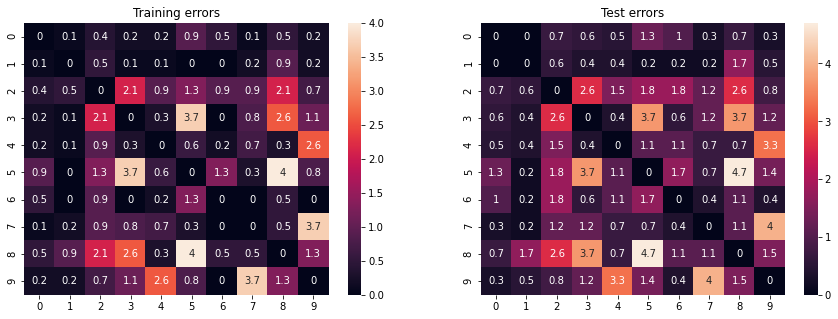

In [42]:
import pandas as pd
import seaborn as sns

learning_rate = 0.2
nepochs = 500

train_error = pd.DataFrame(np.zeros((10, 10)))
test_error = pd.DataFrame(np.zeros((10, 10)))

for n1, n2 in itertools.combinations(list(range(10)), 2):
    selected_digits = (n1, n2)

    x_filtered, y_filtered = filter_digits(x, y, selected_digits)
    x_train, x_test, y_train, y_test = prepare_train_test(x_filtered, y_filtered)
    
    w, b = initialize_params(n=x_train.shape[0], random="False")
    model, metrics = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=500, alpha=0.2, cost_type="CE", debug=False)

    train_errors = int(min(metrics.train_errors)*1000) / 10
    test_errors = int(min(metrics.test_errors)*1000) / 10
    train_error.loc[n1, n2] = train_errors
    train_error.loc[n2, n1] = train_errors
    test_error.loc[n1, n2] = test_errors
    test_error.loc[n2, n1] = test_errors

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training errors")
ax2.set_title("Test errors")
sns.heatmap(train_error, annot=True, ax=ax1)
sns.heatmap(test_error, annot=True, ax=ax2)